In [46]:
using MAT
using Images, FileIO

In [2]:
path_to_processed_mat = "/userfiles/gsoykan20/mpii_human_pose/cropped/dataset.mat"

"/userfiles/gsoykan20/mpii_human_pose/cropped/dataset.mat"

In [139]:
file = matopen(path_to_processed_mat)
dataset = read(file, "dataset")
close(file);

In [5]:
dataset

Dict{String,Any} with 3 entries:
  "image"  => Any["/userfiles/gsoykan20/mpii_human_pose/cropped/im00005_1.png" …
  "size"   => Any[[3.0 391.0 295.0] [3.0 446.0 368.0] … [3.0 503.0 371.0] [3.0 …
  "joints" => Any[Any[Int32[0 175 261; 1 173 178; … ; 12 187 126; 13 226 72]] A…

In [65]:
path_to_single_person_mat = "/userfiles/gsoykan20/mpii_human_pose/cropped/annolist-singlePerson-h400.mat"
path_to_full_mat = "/userfiles/gsoykan20/mpii_human_pose/cropped/annolist-full-h400.mat"
path_to_multi_person_mat = "/userfiles/gsoykan20/mpii_human_pose/cropped/annolist-multPerson-h400.mat"

"/userfiles/gsoykan20/mpii_human_pose/cropped/annolist-multPerson-h400.mat"

In [30]:
file = matopen(path_to_single_person_mat)
single_person = read(file)
close(file);

In [66]:
file = matopen(path_to_full_mat)
full_people = read(file)
close(file);

In [32]:
file = matopen(path_to_multi_person_mat)
multi_person = read(file)
close(file);

In [141]:
image_path_from_dataset = dataset["image"][1, 20000]

"/userfiles/gsoykan20/mpii_human_pose/cropped/im02233_7.png"

In [33]:
single_person

Dict{String,Any} with 1 entry:
  "annolist" => Dict{String,Any}("imgnum"=>Any[1.0 2.0 … 19184.0 19185.0],"imag…

In [144]:
image_paths = map(x -> x["name"], multi_person["annolist"]["image"])
image_paths = vec(image_paths);
found_idx = findlast(x -> x == image_path_from_dataset ,image_paths)
println(found_idx)

815


In [111]:
single_person["annolist"]["annorect"][1, 15]

Dict{String,Any} with 7 entries:
  "objpos"     => Dict{String,Any}("x"=>230.236,"y"=>160.453)
  "x1"         => 135.523
  "y1"         => 80.7839
  "annopoints" => Dict{String,Any}("point"=>Dict{String,Any}("x"=>Any[246.392 1…
  "x2"         => 190.122
  "y2"         => 143.74
  "scale"      => 3.58983

In [35]:
# TODO: continue from here
single_person["annolist"]["image"]

1×19185 Array{Any,2}:
 Dict{String,Any}("name"=>"/userfiles/gsoykan20/mpii_human_pose/cropped/im00005_1.png")  …  Dict{String,Any}("name"=>"/userfiles/gsoykan20/mpii_human_pose/cropped/im24985_5.png")

In [64]:
multi_person["annolist"]

Dict{String,Any} with 4 entries:
  "imgnum"     => Any[1.0 2.0 … 9697.0 9698.0]
  "image"      => Any[Dict{String,Any}("name"=>"/userfiles/gsoykan20/mpii_human…
  "annorect"   => Any[Dict{String,Any}("objpos"=>Dict{String,Any}("x"=>92.4539,…
  "image_size" => Any[[256.0 224.0] [238.0 187.0] … [503.0 371.0] [437.0 329.0]]

In [147]:
test_image_path = multi_person["annolist"]["image"][1, 815]["name"]

"/userfiles/gsoykan20/mpii_human_pose/cropped/im02233_7.png"

In [148]:
multi_person["annolist"]["annorect"][1, 815]

Dict{String,Any} with 7 entries:
  "objpos"     => Dict{String,Any}("x"=>186.037,"y"=>286.381)
  "x1"         => 130.335
  "y1"         => 67.8573
  "annopoints" => Dict{String,Any}("point"=>Dict{String,Any}("x"=>Any[166.755 1…
  "x2"         => 188.179
  "y2"         => 127.844
  "scale"      => 0.933535

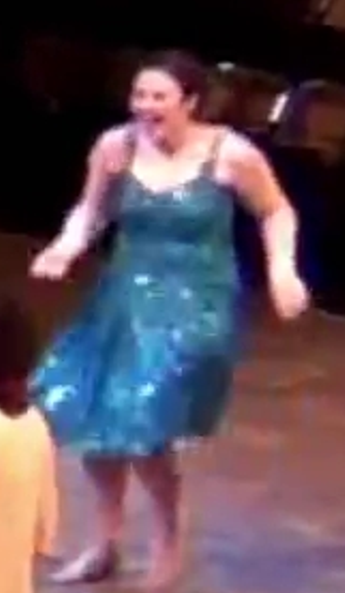

In [149]:
test_img = load(test_image_path)

In [150]:
size(test_img)

(593, 345)

In [172]:
include("mpii.annotation.reader.jl")

raw_data_to_data_item (generic function with 1 method)

In [173]:
cropped_dataset = read_cropped_mpii_annotations(;should_shuffle=false)

Dict{String,Any} with 5 entries:
  "image"     => ["/userfiles/gsoykan20/mpii_human_pose/cropped/im00005_1.png",…
  "annorect"  => Any[Dict{String,Any}("objpos"=>Dict{String,Any}("x"=>158.241,"…
  "size"      => [[3.0 391.0 295.0], [3.0 446.0 368.0], [3.0 252.0 170.0], [3.0…
  "joints"    => Array{Any,2}[[Int32[0 175 261; 1 173 178; … ; 12 187 126; 13 2…
  "is_single" => Any[true, true, true, true, true, true, true, true, true, true…

In [178]:
cropped_dataset["annorect"][1]

Dict{String,Any} with 7 entries:
  "objpos"     => Dict{String,Any}("x"=>158.241,"y"=>170.14)
  "x1"         => 180.088
  "y1"         => 66.2022
  "annopoints" => Dict{String,Any}("point"=>Dict{String,Any}("x"=>Any[168.834 1…
  "x2"         => 232.388
  "y2"         => 131.08
  "scale"      => 3.02105

In [166]:
image_metas = find_annorect_and_is_single_info(cropped_dataset["image"]);

In [171]:
image_metas[:, 2][1]

Dict{String,Any} with 7 entries:
  "objpos"     => Dict{String,Any}("x"=>158.241,"y"=>170.14)
  "x1"         => 180.088
  "y1"         => 66.2022
  "annopoints" => Dict{String,Any}("point"=>Dict{String,Any}("x"=>Any[168.834 1…
  "x2"         => 232.388
  "y2"         => 131.08
  "scale"      => 3.02105